In [ ]:
# !pip install fbprophet

In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import sklearn

from pandas import to_datetime
from pandas import DataFrame

In [ ]:
df=pd.read_csv('/content/drive/My Drive/Python/OilProduction/37145_Prod_noNAN.csv',
               usecols=['FirstOfMonth','OilProduced'],
               )
# df['y'] = np.log(df['y'])
df=df.rename(columns={"FirstOfMonth": "ds", "OilProduced": "y"})
df['ds']= to_datetime(df['ds'])
# model = Prophet(changepoint_prior_scale = 0.2,
#                 # growth='logistic',
#                 weekly_seasonality=False,
#                 daily_seasonality=False
#                 )  #By default, "changepoint_prior_scale" is set to 0.05. Increasing it will make the trend more flexible
# model.fit(df)
df

,ds,y
0,2013-10-01,8339
1,2013-11-01,9566
2,2013-12-01,6654
3,2014-01-01,4951
4,2014-02-01,3849
...,...,...
78,2020-04-01,221
79,2020-05-01,216
80,2020-06-01,221
81,2020-07-01,211


In [ ]:
# Hyperparameter tuning
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import itertools

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0]
}

cutoffs = pd.to_datetime(['2018-08-01','2019-08-01'])

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m,cutoffs=cutoffs,horizon = '365 days' ,parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f439caa20f0>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f439c37fa58>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f439caed860>
INFO:fbprophet:Disabling weekly seaso

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                      0.01                    0.001  1510.599048
1                      0.01                    0.010  1499.114058
2                      0.01                    0.100  1456.271358
3                      0.01                    1.000  1439.779940
4                      0.05                    0.001  1166.947455
5                      0.05                    0.010  1152.269131
6                      0.05                    0.100   468.336776
7                      0.05                    1.000  1132.650396
8                      0.10                    0.001   139.542717
9                      0.10                    0.010   192.111228
10                     0.10                    0.100   240.291988
11                     0.10                    1.000   194.923507
12                     0.20                    0.001   103.558628
13                     0.20                    0.010   146.128943
14        

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 1, 'seasonality_prior_scale': 10.0}


In [ ]:
# df[58:]

,ds,y
58,2018-08-01,295
59,2018-09-01,265
60,2018-10-01,301
61,2018-11-01,247
62,2018-12-01,276
63,2019-01-01,247
64,2019-02-01,224
65,2019-03-01,220
66,2019-04-01,220
67,2019-05-01,215


In [ ]:
model = Prophet(changepoint_prior_scale = 1,
                seasonality_prior_scale = 0.01
                )  #By default, "changepoint_prior_scale" is set to 0.05. Increasing it will make the trend more flexible
model.fit(df[:58])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future=df['ds'][58:]
future = DataFrame(future).reset_index(drop=True)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# future.head()

          ds        yhat  yhat_lower  yhat_upper
0 2018-08-01  333.133043    4.258613  683.802765
1 2018-09-01  247.290323  -95.656738  564.917052
2 2018-10-01  131.259015 -232.790418  495.271535
3 2018-11-01  585.490421  192.318323  947.035021
4 2018-12-01  287.771666 -175.655902  738.751990


Text(0.5, 1.0, 'Oil Production (Traing & Predicted Datasets)')

<Figure size 864x576 with 0 Axes>

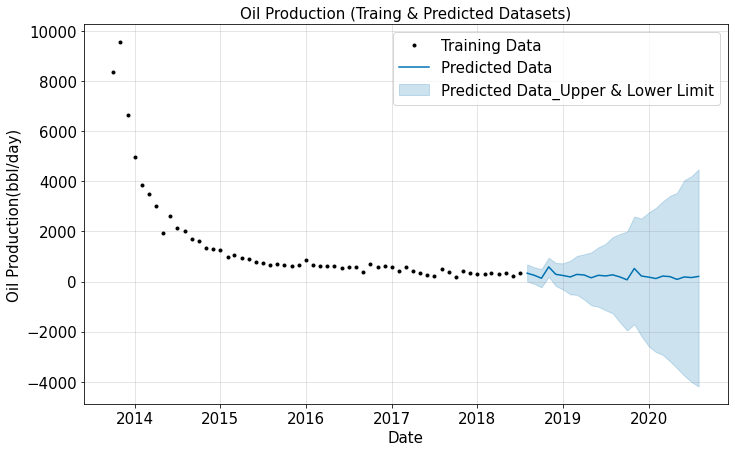

In [ ]:
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
# forecast.head()
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
plt.figure(figsize=(12,8))
model.plot(forecast)
plt.ylabel('Oil Production(bbl/day)',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.legend(['Training Data', 'Predicted Data','Predicted Data_Upper & Lower Limit'],loc='upper right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production (Traing & Predicted Datasets)',fontsize=15)

Text(0.5, 1.0, 'Oil Production: Actual VS. Predicted')

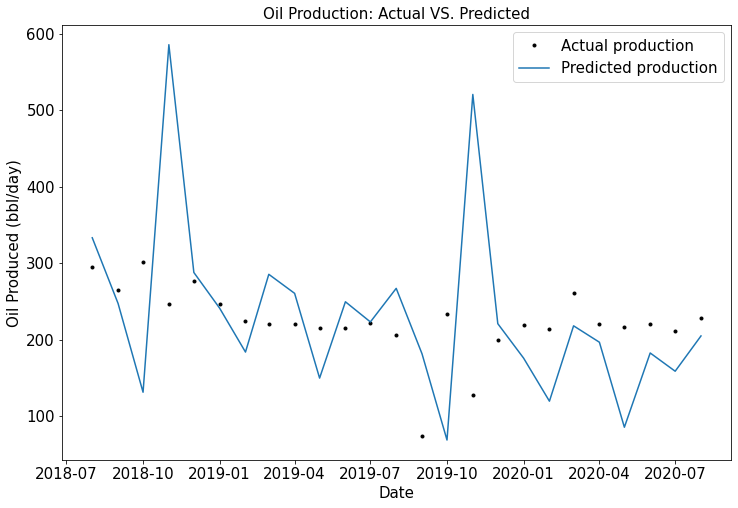

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

x1 = forecast['ds']
y1 = forecast['yhat']
# y2 = forecast['yhat_lower']
# y3 = forecast['yhat_upper']
y4 = df['y'][58:]
plt.figure(figsize=(12,8))
plt.plot(x1,y4,'.',color='black', label='Actual Production')
plt.plot(x1,y1,label='Predicted production')
# plt.plot(x1,y2)
# plt.plot(x1,y3)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Oil Produced (bbl/day)',fontsize=15)
plt.legend(loc='upper right',fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production: Actual VS. Predicted Production',fontsize=15)
# plt.show()

# import matplotlib.ticker as ticker
# import matplotlib.dates as mdates
# ax = plt.axes()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) #'%Y-%m-%d %H:%M:%S'
# ax.xaxis.set_major_locator(ticker.MultipleLocator(182.5))
# ax.set_xlim(pd.Timestamp('2018-07'),pd.Timestamp('2020-07'))
# ax.set_ylim(0,1000)

Evaluate the model

In [ ]:
# calculate MAE between expected and predicted values for december
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error

y_true = df['y'][58:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
r2=r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('MAE: %.2f' % mae)
print('R2 score: %.2f' % r2)
print('rmse: %.2f' % rmse)

MAE: 81.05
R2 score: -6.64
rmse: 124.96


1、均方误差：MSE（Mean Squared Error）
2、均方根误差：RMSE（Root Mean Squard Error）RMSE=sqrt（MSE）。
3、平均绝对误差：MAE（Mean Absolute Error）
4、决定系数：R2（R-Square）
一般来说，R-Squared 越大，表示模型拟合效果越好。R-Squared 反映的是大概有多准，因为，随着样本数量的增加，R-Square必然增加，无法真正定量说明准确程度，只能大概定量。

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

mse = mean_squared_error(testY,testPredict)
rmse = np.sqrt(mean_squared_error(testY,testPredict))
mae = mean_absolute_error(testY,testPredict)
r2 = r2_score(testY,testPredict)

In [ ]:
# forecast

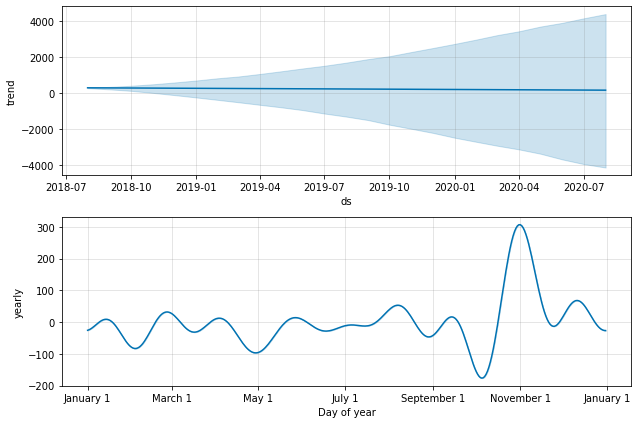

In [ ]:
# fig=model.plot_components(forecast)

plt.figure(figsize=(10,7))
model.plot_components(forecast)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Day of Year',fontsize=12)
plt.ylabel('Yearly Trend',fontsize=12)


# plt.figure(figsize=(12,8))
# x1 = forecast['ds']
# y1 = forecast['yearly']
# plt.plot(x1,y1,label='Yearly Trend')

# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.title('Trend of Yearly Production',fontsize=15)